In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
import matplotlib.cm as mpcm
import sklearn.mixture as sm

# An Introduction to Simulation-Based Inference

### Stephen Feeney, Royal Society URF @ UCL

[github.com/sfeeney/sbi_intro](https://github.com/sfeeney/sbi_intro)

### Traditional Bayesian inference not always possible

<figure style="float: right;">
  <img src="resources/lsst_cov.png" alt="LSST cov" style="width: 400px;">
  <figcaption style="text-align: center; font-style: italic">[<a href="https://doi.org/10.1093/mnras/stx1261">Krause et al. '17</a>]</figcaption>
</figure>

Specification, characterisation or evaluation of likelihood intractable in many settings

LSS: $P({\rm galaxy}|{\rm cosmology})$ not analytic

Large empirical covariance matrices too computationally expensive

Partitioning likelihoods lead to combinatorial explosions

### Simulation typically is possible though

<figure style="float: right;">
  <video src="resources/lss.mov" controls loop autoplay style="float: right; width: 500px;">
      Your browser does not support the video tag
  </video>
  <figcaption style="text-align: center; font-style: italic">[<a href="https://www.tng-project.org/media/">The IllustrisTNG Project</a>]</figcaption>
</figure>

Often extremely complex simulation!

Can simulate data to compare with observations and determine viability of input parameters

Don't have to evaluate likelihood to learn physics: use **simulation-based inference**

How do we do this in principled, Bayesian way?

### Demonstrate using **very** simple model

One underlying parameter, $\theta$

One potential observable, $\hat{\theta}$

Simple analytic forms for prior, $P(\theta)$, and sampling distribution, $P(\hat{\theta}|\theta)$

Pick something interesting for the prior: a two-component Gaussian mixture

In [2]:
# features defining two-component Gaussian mixture prior
frac_1 = 0.4
fracs = np.array([frac_1, 1.0 - frac_1])
mus = np.array([10.0, 13.0])
sigs = np.array([1.0, 0.5])

# function to draw from the prior
def prior_sample(n_samples, fracs=fracs, mus=mus, sigs=sigs):
    
    # loop over desired number of samples
    samples = np.zeros(n_samples)
    for i in range(n_samples):
    
        # pick component and draw from its Gaussian
        comp = npr.choice(2, 1, p=fracs)
        samples[i] = npr.randn() * sigs[comp] + mus[comp]
        
    return samples

Let's draw some samples from the prior to see what it looks like.

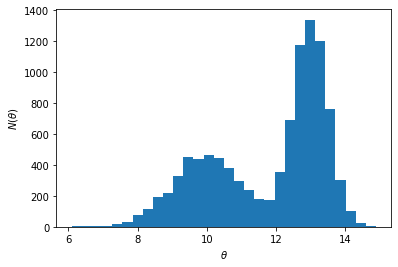

In [3]:
n_samples = 10000
t = prior_sample(n_samples)
mp.hist(t, bins=30)
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$N(\theta)$')

Define the *sampling distribution* of the data, $P(\hat{\theta}|\theta)$, as a Poisson distribution. This means our data will be *discrete*.

In [4]:
# simulate discrete data given parameter value
def data_sample_poisson(theta):
    
    # determine desired number of samples
    n_samples = len(theta)
    
    # return (Poisson) noisy measurement
    return npr.poisson(theta, n_samples)

We can now generate the *joint distribution* of the parameter and data, $P(\theta,\hat{\theta}) = P(\theta) \, P(\hat{\theta}|\theta)$. 

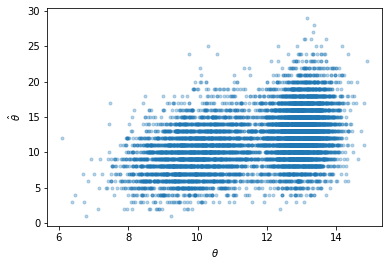

In [5]:
# simulate some potential data conditioned on our parameter draws
d = data_sample_poisson(t)

# plot our parameter-data pairs: these are drawn from the joint distribution
mp.plot(t, d, '.', alpha=0.3)
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$\hat{\theta}$')

### Why is that useful?

Alternative way to write joint: $P(\theta,\hat{\theta}) = P(\hat{\theta}) \, P(\theta|\hat{\theta})$

If we do the experiment and measure $\hat{\theta}_{obs}$, we can get *posterior* from joint:

- $P(\theta|\hat{\theta} = \hat{\theta}_{obs}) \propto P(\theta,\hat{\theta}=\hat{\theta}_{obs})$!

Just slice through joint distribution at observed data

This is pure **likelihood-free inference** (LFI) *\[[Rubin '84](https://doi.org/10.1214%2Faos%2F1176346785)\]*

### Pure Likelihood-Free Inference: prep

First, generate a ground truth value of $\theta$ and an observation, $\hat{\theta}_{obs}$.

In [6]:
# draw a true value of theta and simulate some data (our observations)
theta_true = prior_sample(1)
d_obs = data_sample_poisson(theta_true)
print('ground truth:', theta_true)
print('observation:', d_obs)

ground truth: [9.412682]
observation: [10]


### Pure Likelihood-Free Inference: implementation

1. Draw many samples from prior
2. Simulate some data for each prior draw
2. Keep prior samples whose data exactly match observation, $\hat{\theta}_{obs}$.

In [7]:
# 1. draw from prior
t = prior_sample(n_samples)

# 2. simulate data
d = data_sample_poisson(t)

# 3. keep prior samples whose data match observation
match = d == d_obs

What does this look like in terms of the joint distribution?

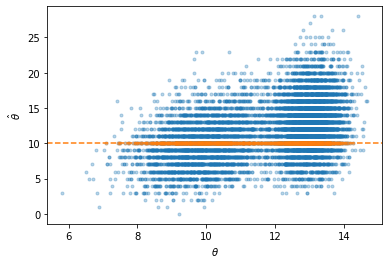

In [8]:
# plot all draws from joint distribution
mp.plot(t, d, '.', alpha=0.3)

# pick out draws whose data match our observation
mp.plot(t[match], d[match], '.', alpha=0.3)
mp.axhline(d_obs, color='C1', ls='--')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$\hat{\theta}$')

### How do we estimate the posterior?
Simply histogram the retained prior samples. Pow!

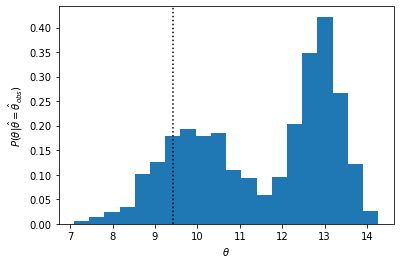

In [9]:
# estimate posterior using pure likelihood-free inference
mp.hist(t[match], bins=20, density=True)

# overlay ground truth
mp.axvline(theta_true, color='k', ls=':')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')

In this case, we can write down the posterior analytically...

In [10]:
# posterior for Gaussian-mixture prior and Poisson measurement
def analytic_pgmm_posterior(theta_grid, d_obs, fracs, mus, sigs):
    
    # prior is mixture of Gaussians
    # NB: dropping constant terms everywhere
    prior = fracs[0] / sigs[0] * np.exp(-0.5 * ((theta_grid - mus[0]) / sigs[0]) ** 2) + \
            fracs[1] / sigs[1] * np.exp(-0.5 * ((theta_grid - mus[1]) / sigs[1]) ** 2)
    
    # likelihood is Poisson
    like = theta_grid ** d_obs * np.exp(-theta_grid)
    
    # un-normalized posterior is the product of likelihood and prior!
    post = prior * like
    return post / np.trapz(post, theta_grid)

...so we can check everything is working as expected!

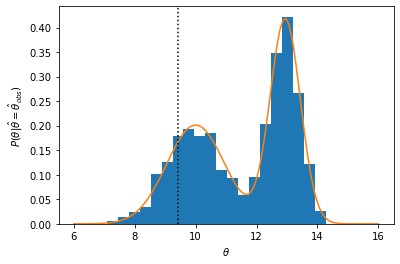

In [11]:
# LFI posterior
mp.hist(t[match], bins=20, density=True)

# analytic posterior
theta_grid = np.linspace(6.0, 16.0, 100)
mp.plot(theta_grid, analytic_pgmm_posterior(theta_grid, d_obs, fracs, mus, sigs))

# ground truth
mp.axvline(theta_true, color='k', ls=':')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')

### Pure Likelihood-Free Inference: comments

<img src="resources/socks.png" alt="pydelfi SNe" style="width: 400px; float: right;">

No likelihood evaluation, just simulation

No approximations (other than sampling)!

But ***very*** simple setting: one discrete observable

Thought experiment (but good for [inferring sock counts](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman/))

Most(?) data continuous: how do we do simulation-based inference then?

### A Reality Check

Let's suppose the sampling distribution is Gaussian, keeping same prior.

In [12]:
# simulate discrete data given parameter value
sig_noise = 1.0
def data_sample(theta, sig_noise=sig_noise):
    
    # determine desired number of samples
    n_samples = len(theta)
    
    # return (Gaussian) noisy measurement
    return theta + npr.randn(n_samples) * sig_noise

# again, simulate some data given our true value of theta
d_obs = data_sample(theta_true)
print('ground truth:', theta_true)
print('observation:', d_obs)

ground truth: [9.412682]
observation: [8.967685]


Try pure LFI: draw params; simulate potential data; no matches...

number of exact matches: 0


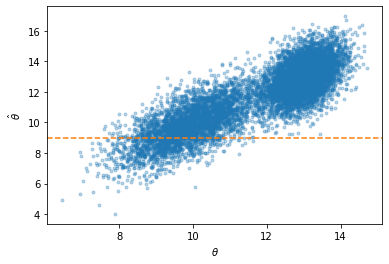

In [13]:
# 1. 2. 3. LFI!
t = prior_sample(n_samples)
d = data_sample(t)
match = d == d_obs
print('number of exact matches:', np.sum(match))
mp.plot(t, d, '.', alpha=0.3)
mp.xlabel(r'$\theta$')
mp.ylabel(r'$\hat{\theta}$')
_ = mp.axhline(d_obs, color='C1', ls='--')

### What if we weren't so picky?

Accept samples within some distance, $\epsilon$, of the observation: e.g., if $\sqrt{(\hat{\theta} - \hat{\theta}_{obs})^2} < \epsilon$.

This is **Approximate Bayesian Computation** (ABC) *\[[Tavaré et al. '97](https://www.genetics.org/content/145/2/505)\]*

In [14]:
# pick out draws from prior nearly matching our observation
epsilon = 0.1
match = np.sqrt((d - d_obs) ** 2) < epsilon
print('number of near matches:', np.sum(match))

number of near matches: 200


What does that look like in terms of the joint distribution?

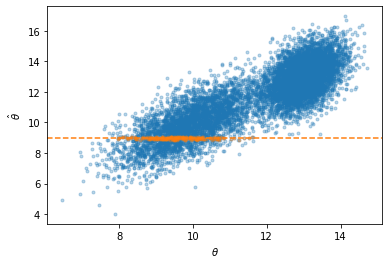

In [15]:
# plot all draws from joint distribution
mp.plot(t, d, '.', alpha=0.3)

# pick out draws whose data nearly match our observation
mp.plot(t[match], d[match], '.', alpha=0.3)
mp.axhline(d_obs, color='C1', ls='--')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$\hat{\theta}$')

And what does the resulting posterior look like?

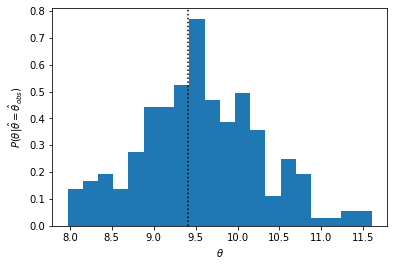

In [16]:
# estimate posterior using ABC (parameter draws whose data nearly match observations)
mp.hist(t[match], bins=20, density=True)

# overlay truth
mp.axvline(theta_true, color='k', ls=':')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')

As before, we can write down the posterior in this setting...

In [17]:
def analytic_posterior(theta_grid, d_obs, fracs, mus, sigs, sig_noise):
    
    # prior is mixture of Gaussians
    # NB: dropping constant terms everywhere
    prior = fracs[0] / sigs[0] * np.exp(-0.5 * ((theta_grid - mus[0]) / sigs[0]) ** 2) + \
            fracs[1] / sigs[1] * np.exp(-0.5 * ((theta_grid - mus[1]) / sigs[1]) ** 2)
    
    # likelihood is Gaussian
    like = np.exp(-0.5 * ((d_obs - theta_grid) / sig_noise) ** 2)
    
    # posterior is the product of likelihood and prior!
    post = prior * like
    return post / np.trapz(post, theta_grid)

...so we can check on performance. Which is a little ratty!

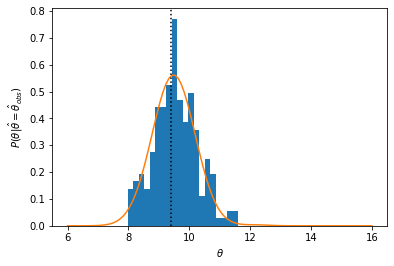

In [18]:
# estimate posterior using ABC
mp.hist(t[match], bins=20, density=True)

# overlay analytic posterior and truth
mp.plot(theta_grid, analytic_posterior(theta_grid, d_obs, fracs, mus, sigs, sig_noise))
mp.axvline(theta_true, color='k', ls=':')
mp.xlabel(r'$\theta$')
_ = mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')

### Can we pick a better $\epsilon$?

$\epsilon$ too small: wasteful, noisy posterior

$\epsilon$ too large: posterior deviates from truth

In [19]:
# cheeky function tidying up the following cell
def redo_abc(t, d, d_obs, epsilon):
    
    # update parameter values whose data nearly match the observation
    match = np.sqrt((d - d_obs) ** 2) < epsilon
    print('number of near matches:', np.sum(match))
    
    # plot ABC histogram with analytic truth overlaid
    mp.hist(t[match], bins=20, density=True)
    mp.plot(theta_grid, analytic_posterior(theta_grid, d_obs, fracs, mus, sigs, sig_noise))
    mp.axvline(theta_true, color='k', ls=':')
    mp.xlabel(r'$\theta$')
    _ = mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')

number of near matches: 48


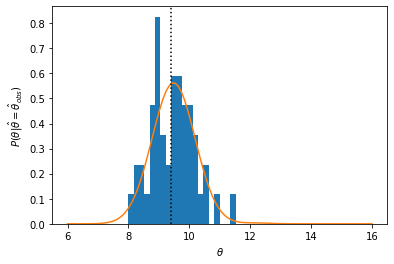

In [27]:
epsilon = 0.02
redo_abc(t, d, d_obs, epsilon)

### Approximate Bayesian Computation: comments

Very simple, works for continuous data

Improve efficiency by sampling parameters from approximate posteriors (e.g., astronomical [Sequential Monte Carlo ABC](https://doi.org/10.1016/j.ascom.2017.01.001) and [Population Monte Carlo ABC](https://doi.org/10.1016/j.ascom.2015.09.001)).

Still inefficient (most simulations rejected), especially in high dimensions

Can we find a way to use *all* simulations?

### Yes! Use Density Estimation Likelihood-Free Inference

Use parameter-data pairs to fit joint density, $P(\theta, \hat{\theta})$ (other densities are available) *\[[Bonassi et al. '11](https://doi.org/10.2202/1544-6115.1684)\]*

Smooth fitting functions share information between samples

For simplicity, let's assume a Gaussian mixture model fit here

In [21]:
# define a model for the joint density
gmm = sm.GaussianMixture(2, covariance_type='full')
td_pairs = np.array([t, d]).T
gmm.fit(td_pairs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

What does the fit look like? Pretty good!

In [22]:
# function hiding away rather involved plotting code (from scikit-learn docs
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html)
def plot_gmm_contours(gmm, theta_grid, d_grid):
    
    # GMM score_samples function wants n_samples x n_features input, 
    # and that input should be regularly spaced gridpoints in theta and d
    theta_mgrid, d_mgrid = np.meshgrid(theta_grid, d_grid)
    density = -gmm.score_samples(np.array([theta_mgrid.ravel(), d_mgrid.ravel()]).T)
    
    # plotting function wants densities back in 2D
    # NB: contour levels don't correspond to specific quartiles
    density = density.reshape(theta_mgrid.shape)
    mp.contour(theta_grid, d_grid, density, levels=np.linspace(0, 15, 10), \
               cmap=mpcm.viridis_r, zorder=10)
    mp.xlabel(r'$\theta$')
    mp.ylabel(r'$\hat{\theta}$')

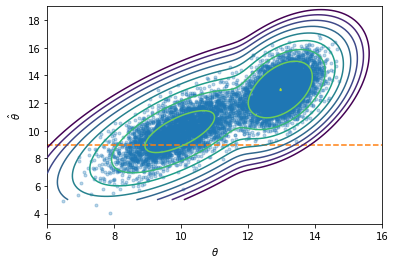

In [23]:
# plot all draws from joint distribution
mp.plot(t, d, '.', alpha=0.3)

# plot fit contours
d_grid = np.linspace(5, 19, 100)
plot_gmm_contours(gmm, theta_grid, d_grid)

# overlay observation
_ = mp.axhline(d_obs, color='C1', ls='--')

### How do we get the posterior?

For a GMM, it's analytic!

$P(\theta|\hat{\theta} = \hat{\theta}_{obs}) = \sum_{i=1}^{n_{comp}} \frac{f_i}{\sqrt{|\boldsymbol{C}_i|}} \exp \left[ \left([\theta, \hat{\theta}_{obs}] - \boldsymbol{\mu}_i \right)^T \boldsymbol{C}_i^{-1} \left([\theta, \hat{\theta}_{obs}] - \boldsymbol{\mu}_i \right) \right]$

In [24]:
# evaluate posterior given Gaussian mixture model fit to joint distribution
def gmm_analytic_posterior(theta_grid, d_obs, gmm):
    
    post = np.zeros(len(theta_grid))    
    for i in range(gmm.n_components):
        inv_cov = np.linalg.inv(gmm.covariances_[i])
        delta = np.array([theta_grid, d_obs]) - gmm.means_[i]
        chi_sq = np.dot(delta, np.dot(inv_cov, delta))
        post += gmm.weights_[i] / np.sqrt(np.linalg.det(gmm.covariances_[i])) * \
                np.exp(-0.5 * chi_sq)
    
    return post / np.trapz(post, theta_grid)

The resulting posterior is an excellent fit to the known true posterior

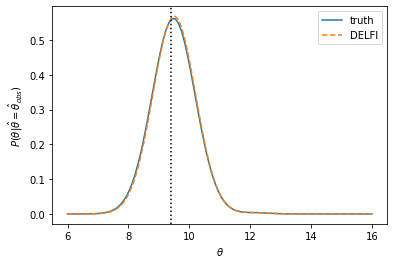

In [25]:
# compare DELFI posterior to known answer
delfi_posterior = gmm_analytic_posterior(theta_grid, d_obs, gmm)
mp.plot(theta_grid, analytic_posterior(theta_grid, d_obs, fracs, mus, sigs, sig_noise), \
        label='truth')
mp.plot(theta_grid, delfi_posterior, ls='--', label='DELFI')
mp.axvline(theta_true, color='k', ls=':')
mp.xlabel(r'$\theta$')
mp.ylabel(r'$P(\theta|\hat{\theta}=\hat{\theta}_{obs})$')
_ = mp.legend(loc='upper right')

### Density Estimation LFI: comments

Efficient: uses all simulations

Don't have to fit joint distribution: can fit, e.g., sampling distribution as function of parameters

Don't have to use GMMs: neural density estimators (NDEs) are much more flexible *\[[e.g., Papamakarios et al. '19](https://arxiv.org/abs/1805.07226)\]*

Data dimensionality still an issue: must compress w/, e.g., approx likelihoods *\[[Alsing et al. '18](https://doi.org/10.1093/mnras/sty819)\]* or neural nets *\[[Charnock et al. '18](https://doi.org/10.1103/PhysRevD.97.083004)\]*

### pyDELFI

<img src="resources/jla_contours_insert.png" alt="pydelfi SNe" style="width: 550px; float: right;">

Public DELFI code written by Justin Alsing, Tom Charnock, Ben Wandelt and me *\[[Alsing et al. '19](https://doi.org/10.1093/mnras/stz1960)\]*

Density estimation with NDEs (MAFs and MDNs)

Applied to supernova cosmology, weak lensing shear maps, more to come...

See [github.com/justinalsing/pydelfi](https://github.com/justinalsing/pydelfi)

<img src="resources/BO_illustration_11_12.png" alt="bolfi" style="width: 400px; float: right;">

### Can we be more efficient?

Yes, using *Bayesian Optimization LFI* (BOLFI) *\[[Gutmann & Corander '16](http://jmlr.org/papers/v17/15-017.html)\]*

Roughly speaking: model log-likelihood as Gaussian Process

Optimal choice of where to sample next: near peak and most uncertain regions of likelihood

Super readable cosmological application (including this figure) by Florent *\[[Leclercq '18](https://doi.org/10.1103/PhysRevD.98.063511)\]*